# Cliff Walking
El agente debe llegar de un punto A a un punto B sin caer en las casillas inferiores, ya que deberia volver al punto A.
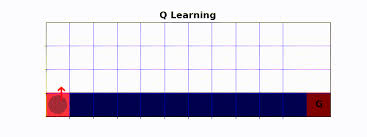

El agente debe aprender a navegar una cuadrícula de 12x4, en donde las coordenadas horizontales $(2, 1)$, $(3, 1)$, $(4, 1)$, $(5, 1)$, $(6, 1)$, $(7, 1)$, $(8, 1)$, $(9, 1)$, $(10, 1)$, $(11, 1)$ representan un abismo, en el que el agente es penalizado con una recompensa de -100 y debe regresar a la coordenada inicial.

In [42]:
WORLD_HEIGHT = 4
WORLD_WIDTH = 12
START = [4, 1]
GOAL = [4, 12];

EPSILON = 0.5
ALPHA = 0.5
GAMMA = 1

ACTION_UP = 1
ACTION_DOWN = 2
ACTION_LEFT = 3
ACTION_RIGHT = 4
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

4-element Array{Int64,1}:
 1
 2
 3
 4

In [35]:
function step(state, action)
    i, j = state
    if action == ACTION_UP
        next_state = [max(i - 1, 1), j]
    elseif action == ACTION_LEFT
        next_state = [i, max(j - 1, 1)]
    elseif action == ACTION_RIGHT
        next_state = [i, min(j + 1, WORLD_WIDTH)]
    elseif action == ACTION_DOWN
        next_state = [min(i + 1, WORLD_HEIGHT), j]
    else
        return false
    end
    
    reward = -1
    if (action == ACTION_DOWN && i == 3 && 2 <= j && j <= 11) ||
        (action == ACTION_RIGHT && state == START)
        reward = -100
        next_state = START
    end
    return next_state, reward
end

step (generic function with 1 method)

In [36]:
function choose_action(state, q_value)
    if rand(1)[1] < EPSILON
        return ACTIONS[rand(1:4)]
    else
        values_ = q_value[state[1], state[2],:]
        action = []
        for i in enumerate(values_)
            action_,value_ = i
            if value_ == maximum(values_)
                push!(action,action_)
            end
        end
        action = action[rand(1:length(action))]
        return action
    end
end

choose_action (generic function with 1 method)

In [37]:
function sarsa(q_value, expected = false, step_size = ALPHA)
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL
        next_state, reward = step(state, action)
        next_action = choose_action(next_state,q_value)
        rewards += reward
        if !expected
            target = q_value[next_state[1], next_state[2], next_action]
        else
            target = 0.0
            q_next = q_value[next_state[1], next_state[2], :]
            best_actions = transpose(hcat(nonzero(q_next == np.max(q_next))...))
            for action_ in ACTIONS
                if action_ in best_actions
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[1], next_state[2], action_]
                else
                    target += EPSILON / len(ACTIONS) * q_value[next_state[1], next_state[2], action_]
                end
            end
        end
        target = target * GAMMA
        q_value[state[1], state[2], action] += step_size * (reward + target - q_value[state[1], state[2], action])
        state = next_state
        action = next_action
    end
    return rewards
end

sarsa (generic function with 3 methods)

In [38]:
function q_learning(q_value, step_size = ALPHA)
    state = START
    rewards = 0.0
    while state != GOAL
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward

        q_value[state[1], state[2], action] += step_size * (
                reward + GAMMA * maximum(q_value[next_state[1], next_state[2], :]) -
                q_value[state[1], state[2], action])
        state = next_state
    end
    return rewards
end

q_learning (generic function with 2 methods)

In [39]:
function print_optimal_policy(q_value)
    optimal_policy = []
    for i in range(1, stop=WORLD_HEIGHT)
        push!(optimal_policy,[])
        for j in range(1, stop=WORLD_WIDTH)
            if [i, j] == GOAL
                append!(optimal_policy[end], 'G')
                continue
            end
            bestAction = argmax(q_value[i, j, :])
            if bestAction == ACTION_UP
                append!(optimal_policy[end], '↑')
            elseif bestAction == ACTION_DOWN
                append!(optimal_policy[end], '↓')
            elseif bestAction == ACTION_LEFT
                append!(optimal_policy[end], '←')
            elseif bestAction == ACTION_RIGHT
                append!(optimal_policy[end], '→')
            end
        end
    end
    for row in optimal_policy
        println(row)
    end
end

print_optimal_policy (generic function with 1 method)

In [40]:
episodes = 500
runs = 50

rewards_sarsa = zeros(episodes)
rewards_q_learning = zeros(episodes)
q_sarsa = zeros((world_height, world_width, 4))
q_q_learning = deepcopy(q_sarsa)

for r ∈ range(1, runs)
    q_sarsa = zeros((world_height, world_width, 4))
    q_q_learning = deepcopy(q_sarsa)

    for i ∈ range(1, episodes)
        rewards_sarsa[i] += sarsa(q_sarsa)
        rewards_q_learning[i] += q_learning(q_q_learning)
    end
end

rewards_sarsa /= runs
rewards_q_learning /= runs

500-element Array{Float64,1}:
 -4025.94
 -1495.1 
 -1152.7 
  -656.16
  -840.78
  -617.62
  -591.22
  -571.6 
  -506.76
  -467.28
  -442.64
  -328.62
  -503.78
     ⋮   
  -829.1 
  -643.06
  -664.6 
  -669.88
  -692.22
  -654.78
  -661.84
  -786.46
  -597.9 
  -857.92
  -954.24
  -781.16

### Resultados del aprendizaje 

In [41]:
println("Sarsa:")
print_optimal_policy(q_sarsa)
println("Q-Learning:")
print_optimal_policy(q_q_learning)

Sarsa:
Any['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']
Any['↑', '↑', '↑', '←', '↑', '→', '↑', '←', '→', '↑', '→', '↓']
Any['↑', '←', '↑', '↑', '↑', '→', '↑', '↑', '↑', '↑', '→', '↓']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'G']
Q-Learning:
Any['↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓']
Any['↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓', '↓']
Any['→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '→', '↓']
Any['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑', 'G']
